In [1]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main'

In [2]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main'

In [3]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main'

### Libary Imports

In [4]:
# Core Libraries ========================================================
import os
import random
import shutil
import numpy as np
import pandas as pd
import cv2
from PIL import Image

# Progress Bar ========================================================
from tqdm.auto import tqdm as notebook_tqdm
from tqdm import tqdm

# Plotting ========================================================
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter Inline Plots ========================================================
%matplotlib inline

# TensorFlow and Keras ========================================================
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, AveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Scikit-learn ========================================================
from sklearn.model_selection import StratifiedKFold, train_test_split, learning_curve
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# SciKeras ========================================================
from scikeras.wrappers import KerasClassifier

# PyTorch ========================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from itertools import zip_longest  # to interleave two loaders safely


### Traffic Sign Detection Prelims

In [5]:
#2. Import the Dataset
##  Baron's Path
signs_dataset = r"C:\Users\Baron\Documents\Grad_School\EE_297A\Project\datasets\signs"

#Construct the Dataset

# Define your target classes
target_classes = [0, 1, 9, 12, 13, 14, 17, 26, 27, 28]

# Map each class to an index: 0–9
class_id_to_index = {class_id: idx for idx, class_id in enumerate(target_classes)}

signs_df = pd.read_csv(f"{signs_dataset}/Train.csv", delimiter = ",")

# Filter to only desired classes
signs_df = signs_df[signs_df["ClassId"].isin(target_classes)]

# Construct full file paths (without moving/copying any image)
signs_df["full_path"] = signs_df["Path"].apply(lambda p: os.path.join(signs_dataset, p))

# Apply to your DataFrame
signs_df["LabelIndex"] = signs_df["ClassId"].map(class_id_to_index)

In [6]:
print(signs_df.iloc[360]["full_path"])

C:\Users\Baron\Documents\Grad_School\EE_297A\Project\datasets\signs\Train/1/00001_00005_00000.png


In [7]:
print(list(map(int, sorted(signs_df["ClassId"].unique()))))
target_classes

[0, 1, 9, 12, 13, 14, 17, 26, 27, 28]


[0, 1, 9, 12, 13, 14, 17, 26, 27, 28]

In [8]:
gtsrb_legend = {
    0: "Speed limit (20)",
    1: "Speed limit (30)",
    9: "No passing",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    17: "No entry",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing"
}

In [9]:
original_dir_train = os.path.join(signs_dataset, 'Train')
original_dir_test = os.path.join(signs_dataset, 'Test') 

processed_dir_train = os.path.join(signs_dataset, 'Train_p')
processed_dir_test = os.path.join(signs_dataset, 'Test_p')

In [10]:
class SignDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "full_path"]
        label = int(self.df.loc[idx, "LabelIndex"])
        
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [11]:
# Use ImageNet normalization for ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create dataset and loader
sign_dataset = SignDataset(signs_df, transform=transform)
sign_loader = DataLoader(sign_dataset, batch_size=32, shuffle=True)

In [12]:
# 80% train, 20% validation split
train_indices, val_indices = train_test_split(
    list(range(len(sign_dataset))), test_size=0.2, random_state=42)

train_subset = Subset(sign_dataset, train_indices)
val_subset = Subset(sign_dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

### Lane  Detection Prelims

In [13]:
IMAGE_FOLDER = r"Z:\EE_297A\dataset\lanes\images"
MASK_FOLDER = r"Z:\EE_297A\dataset\lanes\masks"

In [14]:
def create_dirs_if_not_exist(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("Directory created:", path)
    else:
        print("Directory already exists:", path)

In [15]:
create_dirs_if_not_exist(IMAGE_FOLDER)
create_dirs_if_not_exist(MASK_FOLDER)

Directory already exists: Z:\EE_297A\dataset\lanes\images
Directory already exists: Z:\EE_297A\dataset\lanes\masks


In [16]:
### Copy Images to  the Directory:
"""
This code is a data pre-processing script that goes through the TuSimple dataset’s
train_set/clips directory and copies only the 20th frame of each video clip into a single
flat folder — typically to simplify training or dataset access.
"""

CLIPS_PATH = r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\clips"

# iterate through each directory
for clip_dir in os.listdir(CLIPS_PATH):
    clip_dir_path = os.path.join(CLIPS_PATH, clip_dir)

    print("Processing Clip:", clip_dir)
    # iterate through each sub directory
    for frame_dir in os.listdir(clip_dir_path):
        frame_path = os.path.join(clip_dir_path, frame_dir, "20.jpg")

        # check if file is present
        if not os.path.isfile(frame_path):
            continue

        # create new filename based on last 2 directory names
        clip_name = os.path.basename(os.path.dirname(frame_path))
        date_name = os.path.basename(os.path.dirname(os.path.dirname(frame_path)))
        new_filename = f"{date_name}_{clip_name}.jpg"
        new_file_path = os.path.join(IMAGE_FOLDER, new_filename)

        # copy the file
        shutil.copy(frame_path, new_file_path)

Processing Clip: 0313-1
Processing Clip: 0313-2
Processing Clip: 0531
Processing Clip: 0601


In [17]:
print("Total images in dataset:", len(os.listdir(IMAGE_FOLDER)))

Total images in dataset: 3626


In [18]:
# load the dataset json files
"""
Code Purpose: Load and combine TuSimple lane label JSONs
lines=True tells pandas each line is a separate JSON object (which is true for TuSimple).
Each line describes a labeled frame's lanes + metadata.
"""

df1_313 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0313.json", lines = True)
df2_531 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0531.json", lines = True)
df3_601 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0601.json", lines = True)

# combine into single dataframe
df_json = pd.concat([df1_313, df2_531, df3_601])
df_json.head()

,lanes,h_samples,raw_file
0,"[[-2, -2, -2, -2, 632, 625, 617, 609, 601, 594...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/6040/20.jpg
1,"[[-2, -2, -2, 658, 646, 635, 623, 612, 601, 58...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/5320/20.jpg
2,"[[-2, 570, 554, 538, 522, 505, 489, 473, 456, ...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/23700/20.jpg
3,"[[-2, -2, -2, -2, 555, 542, 530, 517, 505, 493...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/51660/20.jpg
4,"[[-2, -2, -2, 522, 525, 528, 531, 534, 537, 53...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/25680/20.jpg


In [19]:
"""
### Creating the Masks
    1. What is a mask?
    Mask: Creating a binary image (also called a segmentation mask) that marks the lane locations pixel-by-pixel.
    2. Creating a binary image (also called a segmentation mask) that marks the lane locations pixel-by-pixel.
"""

# create function for generating masks
def generate_lane_mask(row):
    # create a mask of all zeros
    mask = np.zeros((728, 1280, 1), dtype=np.uint8)

    # extract data from the row
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create mask: lane = 1, non-lane = 0
    for lane in lanes:
        # exclude -2 datapoints
        h_samples_filtered = [y for x, y in zip(lane, h_samples) if x != -2]
        lane_filtered = [x for x in lane if x != -2]

        # create array of lane points
        lane_points = np.array(list(zip(lane_filtered, h_samples_filtered)))

        # update lane mask
        cv2.polylines(mask, [lane_points], isClosed = False, color = (255, 255, 255), thickness = 15)
    
    # generate mask filename
    raw_file_path = os.path.normpath(raw_file)  # handles / vs \ properly
    clip_name = os.path.basename(os.path.dirname(raw_file_path))     # e.g., 5160
    date_name = os.path.basename(os.path.dirname(os.path.dirname(raw_file_path)))  # e.g., 0313-1
    mask_filename = f"{date_name}_{clip_name}.jpg"
    mask_filename_path = os.path.join(MASK_FOLDER, mask_filename)

    # write the mask image
    cv2.imwrite(mask_filename_path, mask)


In [20]:
# generate masks
from tqdm import tqdm  # ✅ Ensure this import is present

for index, row in tqdm(df_json.iterrows(), total=len(df_json)):
    generate_lane_mask(row)

10


In [21]:
def visualize_image(image_name):
    # get paths
    image_path = os.path.join(IMAGE_FOLDER, image_name)
    mask_path = os.path.join(MASK_FOLDER, image_name)
    
    # read the image and mask
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    
    # plot the image
    plt.figure(figsize = (20, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Road Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")
    
    # show the images
    plt.show()

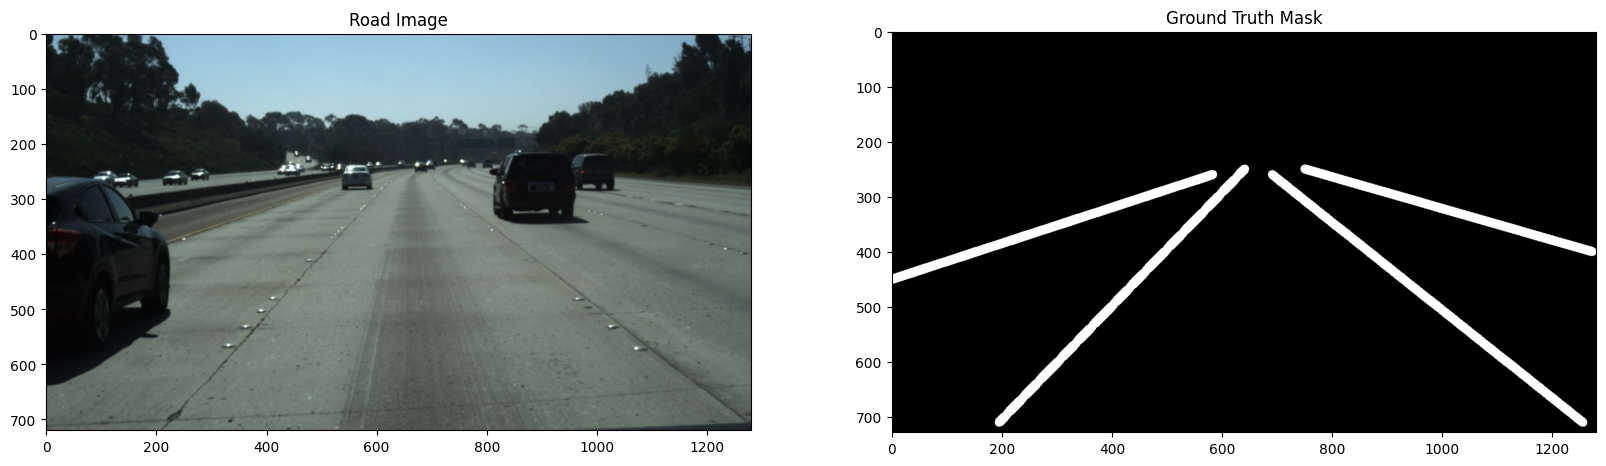

In [22]:
pics2show = 1
for i in range(pics2show):
    image_name = random.choice(os.listdir(IMAGE_FOLDER))
    visualize_image(image_name)

In [23]:
"""
### Training and Testing Splits and Processing
    1. Images
    2. Masks
"""
lane_train_image_folder = r"Z:\EE_297A\dataset\lanes\train\images"
lane_test_image_folder = r"Z:\EE_297A\dataset\lanes\test\images"
lane_train_mask_folder = r"Z:\EE_297A\dataset\lanes\train\masks"
lane_test_mask_folder = r"Z:\EE_297A\dataset\lanes\test\masks"

for folder_path in [lane_train_image_folder, lane_test_image_folder, lane_train_mask_folder, lane_test_mask_folder]:
    create_dirs_if_not_exist(folder_path)

images = [file for file in os.listdir(IMAGE_FOLDER) if file.endswith(".jpg")]
masks = [file for file in os.listdir(MASK_FOLDER) if file.endswith(".jpg")]

# split for train and test
lane_train_images, lane_val_images = train_test_split(images, test_size=0.1, random_state=42)

Directory already exists: Z:\EE_297A\dataset\lanes\train\images
Directory already exists: Z:\EE_297A\dataset\lanes\test\images
Directory already exists: Z:\EE_297A\dataset\lanes\train\masks
Directory already exists: Z:\EE_297A\dataset\lanes\test\masks


In [24]:
"""
### Feature Engineering
    What is feature engineering:
    Feature engineering is the process of creating, transforming, or selecting input variables (features) from raw data in order to improve the performance of a machine learning model.

    1. Image Loading and Preprocessing
    2. Image Sharpening Using a Convolution Kernel
    3. Mask Loading and Normalization
    4.
"""
def load_image(image_path, mask_path):
    size = [224, 224]

    # 1. Image Loading and Preprocessing
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = image / 255.0  

    # 2. Image Sharpening Using a Convolution Kernel
    kernel = tf.constant([[0., -1., 0.],
                          [-1., 5., -1.],
                          [0., -1., 0.]], dtype=tf.float32)
    kernel = tf.reshape(kernel, [3, 3, 1, 1])

    channels = tf.split(image, num_or_size_splits=3, axis=-1)
    sharpened_channels = []
    for c in channels:
        c_sharp = tf.nn.conv2d(tf.expand_dims(c, axis=0), kernel, strides=1, padding="SAME")
        sharpened_channels.append(tf.squeeze(c_sharp, axis=0))
    image = tf.concat(sharpened_channels, axis=-1)
    image = tf.clip_by_value(image, 0.0, 1.0)  

   # 3. Mask Loading and Normalization
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, size)
    mask = mask / 255.0  
    
    return image, mask

def dataset_from_folder(image_folder, mask_folder):
    image_files = sorted([os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(".jpg")])
    mask_files = sorted([os.path.join(mask_folder, file) for file in os.listdir(mask_folder) if file.endswith(".jpg")])

    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(lambda image_path, mask_path: load_image(image_path, mask_path))
    
    return dataset

def display_sample(image_list):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))

    titles = ["Image", "True Mask", "Predicted Mask"]
    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i + 1)
        plt.title(titles[i])
        img = tf.clip_by_value(image_list[i], 0, 1)
        plt.imshow(tf.keras.utils.array_to_img(img))
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()  # ✅ free up memory

In [25]:
# load dataset from folder
lane_train_dataset = dataset_from_folder(lane_train_image_folder, lane_train_mask_folder)
lane_test_dataset = dataset_from_folder(lane_test_image_folder, lane_test_mask_folder)

"""
This code is configuring and optimizing TensorFlow tf.data.Dataset pipelines for training and testing.
 Configuration Setup
"""
# set config
BATCH_SIZE = 16
BUFFER_SIZE = 1000

# optimize for performance improvement
lane_train_dataset = lane_train_dataset.cache().shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
lane_train_dataset = lane_train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
lane_test_dataset = lane_test_dataset.batch(BATCH_SIZE)
lane_test_datset = lane_test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

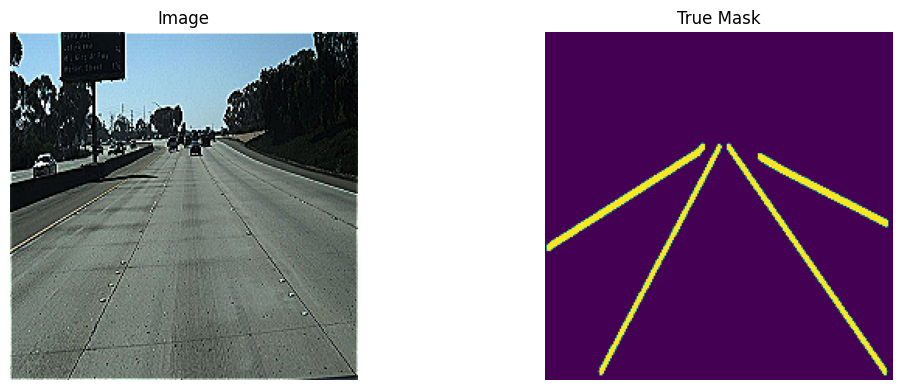

In [26]:
for image, mask in lane_train_dataset.take(1):
    display_sample([image[0], mask[0]])

In [27]:
class TuSimpleSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_list, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

        # ✅ Ensure file_list is a list of strings
        self.file_list = [f if isinstance(f, str) else f.item() for f in file_list]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fname = self.file_list[idx]

        # ✅ Ensure fname is a string (prevent Tensor errors)
        if isinstance(fname, torch.Tensor):
            fname = fname.tolist()  # safer than .item() for non-scalars

        # --- Load image ---
        img_path = os.path.join(self.images_dir, fname)
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # --- Load mask (same name as image) ---
        mask_path = os.path.join(self.masks_dir, fname)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found: {mask_path}")

        # ✅ Resize mask to match model output (360x640)
        mask = cv2.resize(mask, (640, 360), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 127).astype("float32")  # binarize to 0/1

        # --- Apply transforms if any ---
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        # --- Convert to PyTorch tensors ---
        img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0  # (3, H, W)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0).float()           # (1, H, W)
        dummy_class = torch.tensor(0)  # placeholder if not using classification

        return img_tensor, dummy_class, mask_tensor

In [28]:
train_images_dir = lane_train_image_folder  # Z:\...\train\images
train_masks_dir  = lane_train_mask_folder
val_images_dir   = lane_test_image_folder   # Z:\...\test\images
val_masks_dir    = lane_test_mask_folder

In [29]:
images = [f for f in os.listdir(IMAGE_FOLDER) if f.endswith(".jpg")]
lane_train_images, lane_val_images = train_test_split(images, test_size=0.1, random_state=42)

In [30]:
# Step 2: instantiate datasets
lane_train_dataset = TuSimpleSegDataset(train_images_dir, train_masks_dir, lane_train_images)
lane_val_dataset   = TuSimpleSegDataset(val_images_dir, val_masks_dir, lane_val_images)

lane_train_loader = DataLoader(lane_train_dataset, batch_size=16, shuffle=True)
lane_val_loader   = DataLoader(lane_val_dataset, batch_size=16, shuffle=False)

### Model Creation
    Asserting GPU as Device:

In [31]:
# Print Python version
import sys
sys.version

'3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]'

In [32]:
import torch
print("PyTorch version:", torch.__version__)

PyTorch version: 2.4.1


In [33]:
# Check GPU availability
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

CUDA available: True


In [34]:
if cuda_available:
    print("CUDA version (PyTorch built with):", torch.version.cuda)
    print("Number of CUDA devices:", torch.cuda.device_count())

    for i in range(torch.cuda.device_count()):
        print(f"\n[GPU {i}]")
        print("Device Name:", torch.cuda.get_device_name(i))
        print("Total Memory (MB):", round(torch.cuda.get_device_properties(i).total_memory / 1024**2, 2))
        print("Cached Memory (MB):", round(torch.cuda.memory_reserved(i) / 1024**2, 2))
else:
    print("⚠️ No CUDA-compatible GPU detected.")

CUDA version (PyTorch built with): 12.1
Number of CUDA devices: 1

[GPU 0]
Device Name: NVIDIA GeForce RTX 3060 Ti
Total Memory (MB): 8191.38
Cached Memory (MB): 0.0


In [35]:
# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [36]:
class MultiTaskNet(nn.Module):
    def __init__(self, num_classes):
        super(MultiTaskNet, self).__init__()

        # Load pretrained ResNet18 and extract feature layers
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Output: (B, 512, 7, 7)

        # Classification head
        self.class_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        ).to(device)

        # Efficient segmentation decoder (no skip connections)
        self.segmentation_head = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # 7 → 14
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 14 → 28
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),   # 28 → 56
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),    # 56 → 112
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 1, kernel_size=1),  # 1-channel binary mask
            nn.Upsample(size=(360, 640), mode='bilinear', align_corners=False)
        )

    def forward(self, x):
        features = self.encoder(x)

        # Classification branch
        class_out = self.class_head(features)

        # Segmentation branch
        seg_out = self.segmentation_head(features)

        return class_out, seg_out

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskNet(num_classes=10).to(device)

input_tensor = torch.randn(4, 3, 224, 224).to(device)
output_cls, output_seg = model(input_tensor)

print(output_cls.shape)  # (4, 10)
print(output_seg.shape)  # (4, 1, 360, 640)

torch.Size([4, 10])
torch.Size([4, 1, 360, 640])


In [38]:
# Classification loss for traffic sign recognition
criterion_cls = nn.CrossEntropyLoss()

# Segmentation loss for lane detection (binary segmentation)
criterion_seg = nn.BCEWithLogitsLoss()

# Optimizer for the entire model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [39]:
print(len(train_loader), len(lane_train_loader))


572 204


In [40]:
# Devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskNet(num_classes=10).to(device)
device

device(type='cuda')

In [41]:
print(f"Classification batch size: {next(iter(train_loader))[0].shape}")
print(f"Segmentation batch size: {next(iter(lane_train_loader))[0].shape}")

Classification batch size: torch.Size([16, 3, 224, 224])
Segmentation batch size: torch.Size([16, 3, 720, 1280])


### TRAINING PORTION

In [42]:
# 🔁 Load pretrained encoder (from segmentation phase)
state_dict = torch.load("models/phase1_18epoch.pth", map_location=device)
model.load_state_dict(state_dict)

C:\Users\Baron\AppData\Local\Temp\ipykernel_8436\1882237619.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("models/phase1_18epoch.pth", map_loca

<All keys matched successfully>

### MODEL INFERENCE

In [55]:
#model = MultiTaskNet(num_classes=10).to(device)
#model.load_state_dict(torch.load("models/phase2_100epoch.pth", map_location=device))
model.load_state_dict(torch.load("models/phase1.pth", map_location=device))
model.eval()

C:\Users\Baron\AppData\Local\Temp\ipykernel_8436\3947924914.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/phase1.pth", map_loc

MultiTaskNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [44]:
print("\n🔍 Running Classification Evaluation...")

correct = 0
total = 0
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(sign_loader):
        images, labels = images.to(device), labels.to(device)

        out_cls, _ = model(images)  # Only use classification output
        _, predicted = torch.max(out_cls, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"\n🧪 Classification Results:")
print(f"Accuracy:    {accuracy:.2f}%")


🔍 Running Classification Evaluation...


10


🧪 Classification Results:
Accuracy:    89.54%


In [45]:
# ✅ Define test folders (if not already defined)
test_images_dir = lane_test_image_folder
test_masks_dir  = lane_test_mask_folder

# ✅ Get test image filenames
test_images = [f for f in os.listdir(test_images_dir) if f.endswith(".jpg")]

# ✅ Create the dataset
lane_test_dataset = TuSimpleSegDataset(test_images_dir, test_masks_dir, test_images)

# ✅ Wrap in DataLoader
from torch.utils.data import DataLoader

lane_test_loader = DataLoader(lane_test_dataset, batch_size=16, shuffle=False)

In [46]:
# === Metric: Dice Coefficient ===
def dice_coefficient(y_true, y_pred, threshold=0.5, eps=1e-7):
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > threshold).float()
    y_true = y_true.float()

    intersection = (y_pred * y_true).sum(dim=(1, 2, 3))
    union = y_pred.sum(dim=(1, 2, 3)) + y_true.sum(dim=(1, 2, 3))
    dice = (2. * intersection + eps) / (union + eps)
    return dice.mean()


In [56]:
print("\n🔍 Running Segmentation Evaluation...")

test_loss = 0.0
dice_total = 0.0
model.eval()

with torch.no_grad():
    for images, _, masks in tqdm(lane_test_loader):
        images = images.to(device)
        masks = masks.to(device)

        _, out_seg = model(images)  # Only use segmentation output

        loss_seg = criterion_seg(out_seg, masks)
        test_loss += loss_seg.item()
        dice_total += dice_coefficient(masks, out_seg)

avg_test_loss = test_loss / len(lane_test_loader)
avg_dice_score = dice_total / len(lane_test_loader)

print(f"\n🧪 Segmentation Results:")
print(f"Loss:        {avg_test_loss:.4f}")
print(f"Dice Score:  {avg_dice_score:.4f}")


🔍 Running Segmentation Evaluation...


10


🧪 Segmentation Results:
Loss:        0.0468
Dice Score:  0.7689


In [57]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

def show_sample_prediction_overlay(model, dataset, device, index=0, alpha=0.4, color=(1, 0, 0)):
    model.eval()
    
    # Get sample from dataset
    image, _, true_mask = dataset[index]
    image_tensor = image.unsqueeze(0).to(device)  # (1, 3, H, W)

    with torch.no_grad():
        _, pred_mask = model(image_tensor)
        pred_mask = torch.sigmoid(pred_mask)
        pred_mask = (pred_mask > 0.5).float()

    # Convert image to NumPy
    img_np = image.permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
    pred_np = pred_mask.squeeze().cpu().numpy()    # (H', W')

    # 🔧 Resize pred mask to match original image size
    pred_np = cv2.resize(pred_np, (img_np.shape[1], img_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Normalize image to [0, 1] range
    if img_np.max() > 1.0:
        img_np = img_np / 255.0

    # Create color overlay
    overlay = np.zeros_like(img_np)
    overlay[:, :, 0] = color[0]  # R
    overlay[:, :, 1] = color[1]  # G
    overlay[:, :, 2] = color[2]  # B

    # Apply overlay to predicted mask regions
    blended = img_np.copy()
    blended[pred_np == 1] = (1 - alpha) * blended[pred_np == 1] + alpha * overlay[pred_np == 1]

    # Plot side-by-side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(blended)
    plt.title("Overlay: Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


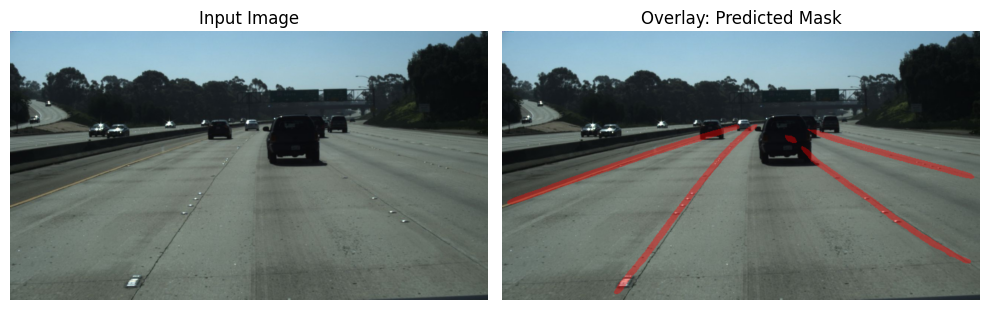

In [58]:
show_sample_prediction_overlay(model, lane_test_dataset, device, index=6, alpha=0.4)